In [240]:
import numpy as np
import pywt
from scipy.signal import filtfilt, butter, iirnotch, lfilter, medfilt, cheby2
from statistics import median, mean, variance
import matplotlib.pyplot as plt
plt.style.use('dark_background')



# Load ECG signal

ecg_signal = np.loadtxt('118e00.csv')

def normalize_signal(signal):
    mean_amplitude = np.mean(np.abs(signal))
    normalized_signal = signal / mean_amplitude
    return normalized_signal

ecg_signal = ecg_signal[:20000]
ecg_signal = ecg_signal-mean(ecg_signal)
ecg_signal = normalize_signal(ecg_signal)

In [ ]:

def print_scalogram(ecg_signal, level=9, wavelet = 'db4'):

    coeffs = pywt.wavedec(ecg_signal-mean(ecg_signal), wavelet, level=level)

    def create_scalogram(coefficients):
        num_levels = len(coefficients)
        max_length = max(len(c) for c in coefficients)
        scalogram = np.zeros((num_levels, max_length))

        for i, c in enumerate(coefficients):
            length = max_length // len(c)  # Adjust the length based on level
            stretched_c = np.repeat(c, length)[:max_length]
            scalogram[i, :len(stretched_c)] = stretched_c

        return scalogram

    # Create the scalogram
    scalogram = create_scalogram(coeffs)

    # Plot the scalogram
    plt.imshow(scalogram, aspect='auto', cmap='jet', interpolation='nearest')
    plt.xlabel('Time (s)')
    plt.ylabel('Scale')
    plt.colorbar(label='Coefficient')
    plt.title('Scalogram')

    # Add white lines between arrays
    for i in range(1, len(coeffs)):
        plt.axhline(i - 0.5, color='white', linewidth=0.5)
    num_columns = scalogram.shape[1]


    num_samples = np.max([len(x) for x in coeffs]) # Assuming you have a data array

    total_time = len(ecg_signal)/360  # Desired total time in seconds
    num_ticks = 4  # Total number of ticks

    tick_spacing = num_samples // num_ticks  # Integer division to get the approximate tick spacing

    # Generate x-axis values based on tick spacing
    x_ticks = [i * tick_spacing for i in range(num_ticks)]

    # Convert x-axis values to time values
    x_tick_labels = [f'{x / num_samples * total_time:.2f}' for x in x_ticks]

    # Set x-axis ticks and labels
    plt.xticks(x_ticks, x_tick_labels)

    plt.show()

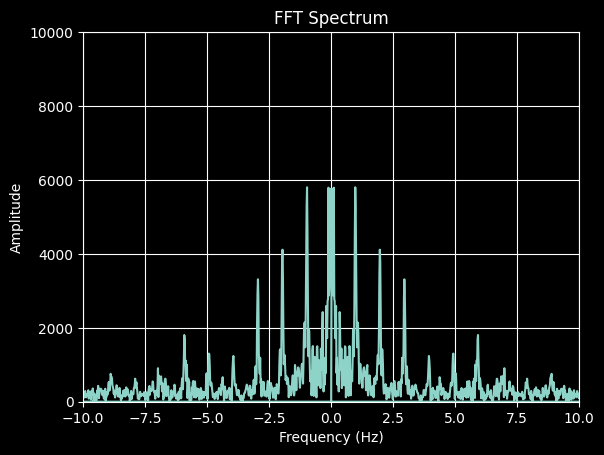

In [274]:


def plot_fft(signal, sample_rate, lim):
    # Compute the FFT
    fft = np.fft.fft(signal)
    
    # Compute the frequency bins
    freq_bins = np.fft.fftfreq(len(signal), 1/sample_rate)
    
    # Take the absolute value of the FFT output
    spectrum = np.abs(fft)
    
    # Plot the spectrum
    plt.figure()
    plt.plot(freq_bins, spectrum)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.title('FFT Spectrum')
    plt.grid(True)
    plt.ylim(0,10000)
    plt.xlim(-lim, lim)
    plt.show()

plot_fft(ecg_signal, 360, 10)


In [268]:
def wav_filter_lvl6(signal,wavelet = 'db4'):
    # Define wavelet and level of decomposition

    level = 6

    # Perform wavelet decomposition
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    new_coeffs = []
    for id, coef in enumerate(coeffs):

        if id==2 or id ==1:
            ncoef = pywt.threshold(np.array(coef), 0.1*mean(abs(coef)), 'hard')
            new_coeffs.append(np.array(ncoef))
        elif id ==3:
            ncoef = pywt.threshold(np.array(coef), 0.5*mean(abs(coef)), 'hard')
            new_coeffs.append(np.array(ncoef))
        else: 
            new_coeffs.append(np.zeros(len(coef)))

    ecg_filtered = pywt.waverec(new_coeffs, wavelet)
    return ecg_filtered


def wav_filter_lvl9(signal,wavelet = 'db4'):
    # Define wavelet and level of decomposition
    level = 9

    # Perform wavelet decomposition
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    new_coeffs = []
    for id, coef in enumerate(coeffs):

        if id == 4 or id == 5:
            ncoef = pywt.threshold(np.array(coef), 0.2*mean(abs(coef)), 'soft')
            new_coeffs.append(np.array(ncoef))
        elif id==6:
            ncoef = pywt.threshold(np.array(coef), mean(abs(coef)), 'soft')
            new_coeffs.append(np.array(ncoef))
        else: 
            new_coeffs.append(np.zeros(len(coef)))

    ecg_filtered = pywt.waverec(new_coeffs, wavelet)
    return ecg_filtered




27.77777777777778


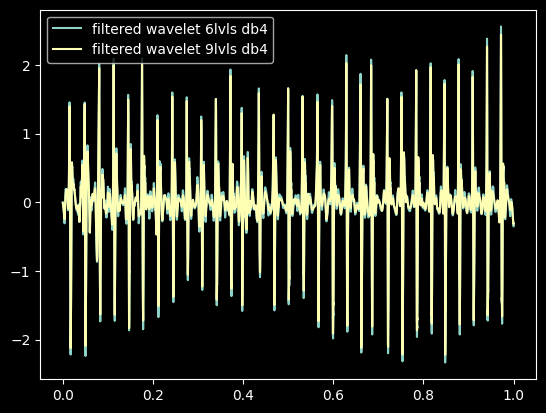

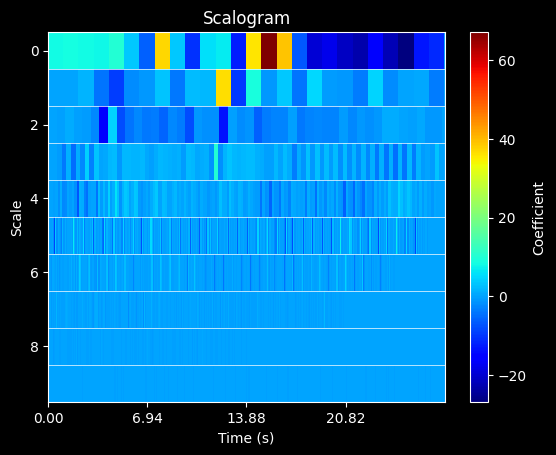

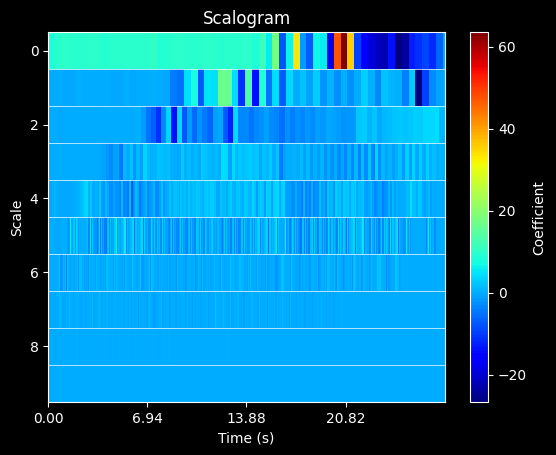

In [238]:

x1 = 1000
x2 = 9000

t = np.linspace(0, 1, x2-x1)
#plt.plot(t, ecg_signal[x1:x2], label='original')
plt.plot(t, (wav_filter_lvl6(ecg_signal, 'db4')[x1:x2]), label='filtered wavelet 6lvls db4')
#plt.plot(t, (wav_filter_lvl6(ecg_signal, 'db20')[x1:x2]), label='filtered wavelet 6lvls db20')
plt.plot(t, (wav_filter_lvl9(ecg_signal, 'db4')[x1:x2]), label='filtered wavelet 9lvls db4')


plt.legend()
plt.show()

print_scalogram(ecg_signal,9,'db4')
plt.show()

print_scalogram(ecg_signal,9,'db20')
plt.show()


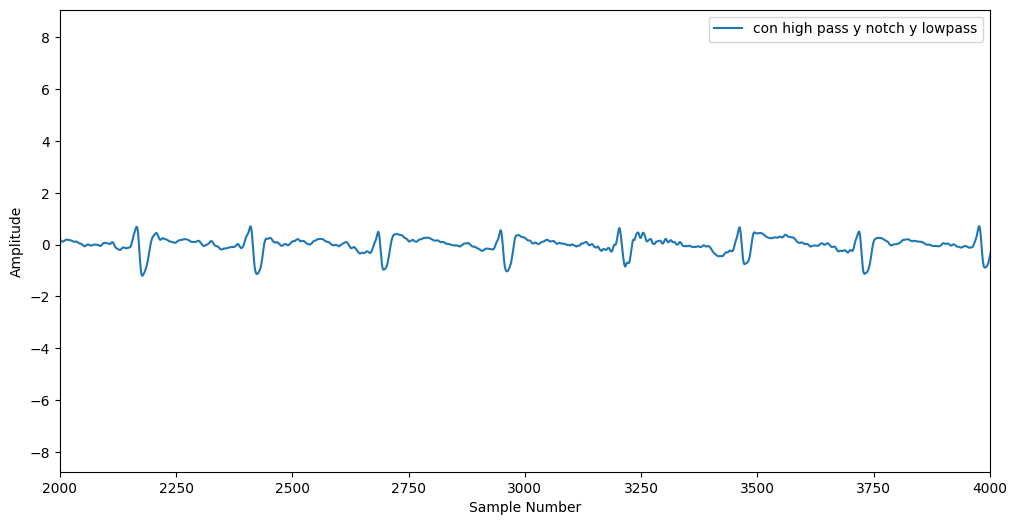

In [18]:
ecg = np.loadtxt('118e00.csv')

# Preprocesar segun paper de 11 pags
fs = 360

plt.figure(figsize=(12, 6))


besaline_wander_filtered_signal = apply_high_pass_filter(ecg, 0.8, fs)
powerline_filtered_signal = apply_notch_filter(besaline_wander_filtered_signal, 50, fs)
emg_filtered_signal = apply_custom_filter(powerline_filtered_signal)
plt.plot(emg_filtered_signal, label='con high pass y notch y lowpass')

plt.xlim(2000,4000)
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

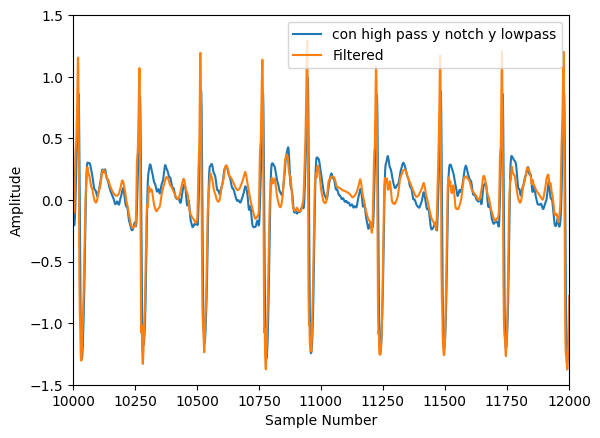

In [61]:
plt.plot(emg_filtered_signal, label='con high pass y notch y lowpass')

plt.plot(apply_high_pass_filter(ecg_filtered, 0.5, 360), label='Filtered')
plt.xlim(10000, 12000)
plt.ylim(-1.5,1.5)
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [60]:
import pandas as pd

In [62]:
ecg_record = pd.read_csv('./hr/mitbih_database/100.csv')


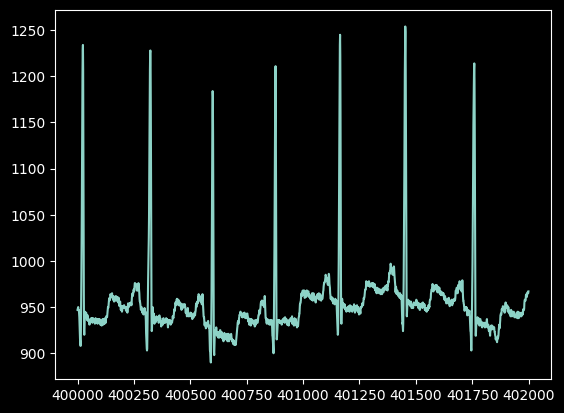

In [71]:
ecg_record
plt.plot(ecg_record["'MLII'"][400000:402000])

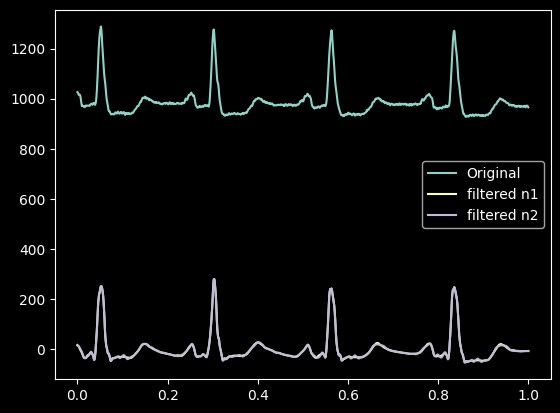

In [87]:
# Load ECG signal
ecg_record = pd.read_csv('./hr/mitbih_database/105.csv')
ecg_signal = np.array(ecg_record["'MLII'"])
#ecg_signal = ecg_signal-mean(ecg_signal)

def wav_filter_1(signal, n):
    # Define wavelet and level of decomposition
    wavelet = 'db4'
    level = 7

    # Perform wavelet decomposition
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    new_coeffs = []
    for id, coef in enumerate(coeffs):
        if id==1 or id==2 or id==3 or id==4:
            '''
            mean_arr = np.convolve(abs(coef), np.ones(n) / n, mode='same')
            new_coeff = np.zeros(len(coef))
            for id, element in enumerate(coef):
                if abs(coef[id])>mean_arr[id]:
                    new_coeff[id] = coef[id]
            new_coeffs.append(new_coeff)
            '''
            new_coeffs.append(coef)
        else: 
            new_coeffs.append(np.zeros(len(coef)))

    ecg_filtered = pywt.waverec(new_coeffs, wavelet)
    return ecg_filtered

def filter_signal2(signal, n):
    # Define wavelet and level of decomposition
    wavelet = 'db4'
    level = 4

    # Perform wavelet decomposition
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    new_coeffs = []
    for id, coef in enumerate(coeffs):
        if id==0:
            new_coeffs.append(coef)
        elif id==1:
            mean_arr = np.convolve(abs(coef), np.ones(n) / n, mode='same')
            new_coeff = np.zeros(len(coef))
            for id, element in enumerate(coef):
                if abs(coef[id])>mean_arr[id]:
                    new_coeff[id] = coef[id]
            new_coeffs.append(new_coeff)
        else: 
            new_coeffs.append(np.zeros(len(coef)))

    # Perform wavelet thresholding

    # Reconstruct filtered signal
    ecg_filtered = pywt.waverec(new_coeffs, wavelet)
    return ecg_filtered
    # Plot original and filtered signals

import matplotlib.pyplot as plt
nums = [5, 10, 25, 60]

x1 = 3000
x2 = 4000
t = np.linspace(0, 1, x2-x1)
plt.plot(t,ecg_signal[x1:x2], label='Original')
plt.plot(t, wav_filter_1(ecg_signal, 50)[x1:x2], label='filtered n1')
plt.plot(t, filter_signal2(wav_filter_1(ecg_signal, 25), 50)[x1:x2], label='filtered n2')

plt.legend()
plt.show()

In [243]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import iirnotch, filtfilt, butter

'''the following code implements e implements a IIR notch filter'''


def notch_filter(signal, Fs = 360, Fnotch = 0.67, BW = 5, Apass = 1 ):
    b, a = iirnotch(Fnotch / (Fs / 2), BW / (Fs / 2), Apass)
    return filtfilt(b, a, signal)


'''This matlab code removes baseline wander using high-pass filter'''


def lowpass_filter(signal, cutoff_freq= 0.667, fs = 360, N = 6):

    # Design the Butterworth high-pass filter
    Wn = cutoff_freq / (fs / 2)
    b, a = butter(N, Wn, btype='high')
    return filtfilt(b, a, signal)

'''filter the signal taking the average of the 8 previous values of it'''

def ma_filt(signal, window_size=8):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')





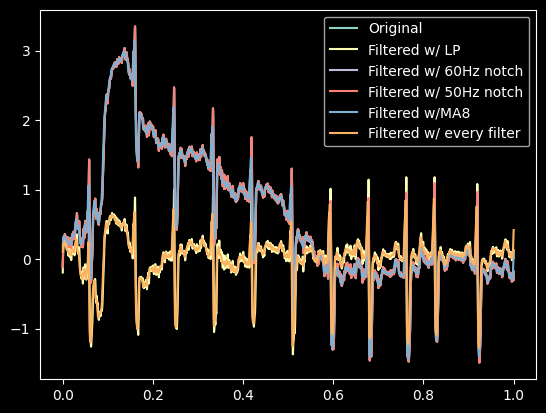

In [244]:

ecg_signal3 = lowpass_filter(ecg_signal)
ecg_signal4 = notch_filter(ecg_signal, Fnotch=60)
ecg_signal5 = notch_filter(ecg_signal, Fnotch=50)
ecg_signal6 = ma_filt(ecg_signal)
ecg_signal7 =  ma_filt(notch_filter(lowpass_filter(ecg_signal), Fnotch=60))


x1 = 4000
x2 = 7000
t = np.linspace(0, 1, x2-x1)
plt.plot(t, ecg_signal[x1:x2], label='Original')
plt.plot(t, ecg_signal3[x1:x2], label='Filtered w/ LP')
plt.plot(t, ecg_signal4[x1:x2], label='Filtered w/ 60Hz notch')
plt.plot(t, ecg_signal5[x1:x2], label='Filtered w/ 50Hz notch')
plt.plot(t, ecg_signal6[x1:x2], label='Filtered w/MA8')
plt.plot(t, ecg_signal7[x1:x2], label='Filtered w/ every filter')

plt.legend()
plt.show()

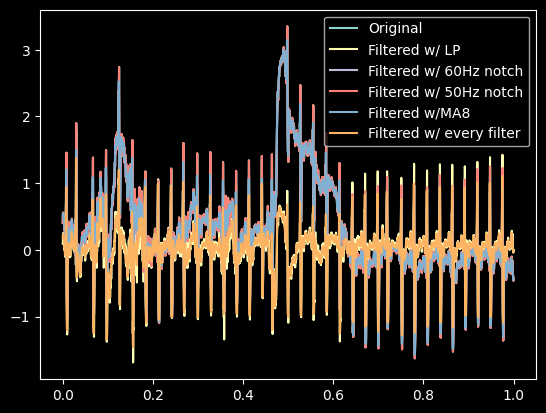

In [245]:
ecg_signal3 = lowpass_filter(ecg_signal)
ecg_signal4 = notch_filter(ecg_signal, Fnotch=60)
ecg_signal5 = notch_filter(ecg_signal, Fnotch=50)
ecg_signal6 = ma_filt(ecg_signal)
ecg_signal7 =  ma_filt(notch_filter(lowpass_filter(ecg_signal), Fnotch=60))


x1 = 1
x2 = 9000
t = np.linspace(0, 1, x2-x1)
plt.plot(t, ecg_signal[x1:x2], label='Original')
plt.plot(t, ecg_signal3[x1:x2], label='Filtered w/ LP')
plt.plot(t, ecg_signal4[x1:x2], label='Filtered w/ 60Hz notch')
plt.plot(t, ecg_signal5[x1:x2], label='Filtered w/ 50Hz notch')
plt.plot(t, ecg_signal6[x1:x2], label='Filtered w/MA8')
plt.plot(t, ecg_signal7[x1:x2], label='Filtered w/ every filter')

plt.legend()
plt.show()